<a href="https://colab.research.google.com/github/SonamTenzin7/FaceRecognition-using-facenet..../blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading face detection model

In [ ]:
!pip install mtcnn

In [ ]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# Check TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Images.zip to Images.zip


In [ ]:
import zipfile

# Path to the uploaded ZIP file
zip_path = list(uploaded.keys())[0]  # Get the name of the uploaded file

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('unzipped_files')  # Extract to a folder named 'unzipped_files'

print("Files unzipped successfully!")

Files unzipped successfully!


In [ ]:
# Read Image
img = cv.imread('/content/unzipped_files/Images/Jigme/4 (1).jpg')
# opencv BGR channel format and plt reads images as RGB hannel Format

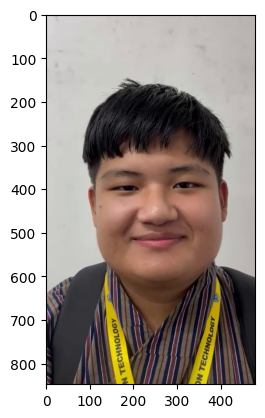

In [ ]:
img = cv.imread('/content/unzipped_files/Images/Jigme/4 (1).jpg')
if img is None:
    print("Error: Image not loaded correctly")
else:
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [ ]:
import lz4
print(lz4.__version__)

4.4.3


In [ ]:
import lz4
print("LZ4 is installed successfully!")

LZ4 is installed successfully!


In [ ]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
results = detector.detect_faces(img)

In [ ]:
results

[{'box': [106, 256, 288, 349],
  'confidence': np.float64(0.9999970197677612),
  'keypoints': {'nose': [np.int64(253), np.int64(465)],
   'mouth_right': [np.int64(319), np.int64(509)],
   'right_eye': [np.int64(316), np.int64(391)],
   'left_eye': [np.int64(186), np.int64(396)],
   'mouth_left': [np.int64(193), np.int64(512)]}}]

In [ ]:
x,y,w,h = results[0]['box']

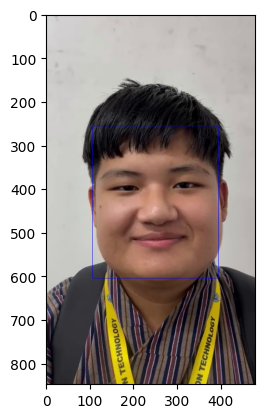

In [ ]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255))
plt.imshow(img)

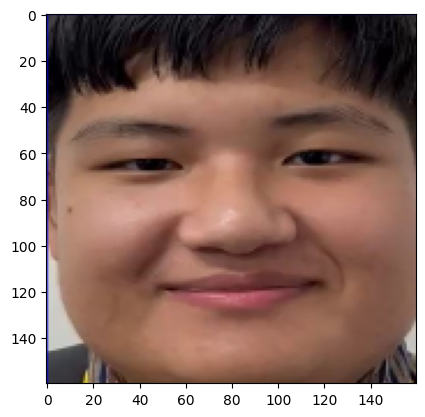

In [ ]:
my_face= img[y:y+h, x:x+w]
# Facenet taskes as input 160
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

array([[[  9,   9, 204],
        [ 24,  23, 129],
        [ 34,  33, 139],
        ...,
        [ 27,  25, 130],
        [ 29,  28, 133],
        [ 27,  26, 131]],

       [[ 19,  18, 172],
        [ 56,  54,  58],
        [ 60,  58,  61],
        ...,
        [ 41,  39,  40],
        [ 46,  44,  45],
        [ 47,  45,  46]],

       [[ 26,  25, 179],
        [ 54,  52,  55],
        [ 69,  67,  69],
        ...,
        [ 42,  41,  42],
        [ 43,  42,  42],
        [ 51,  49,  50]],

       ...,

       [[ 23,  23, 178],
        [ 56,  57,  62],
        [ 56,  57,  62],
        ...,
        [ 71,  61,  62],
        [ 11,   1,   2],
        [ 21,   6,  11]],

       [[ 23,  23, 178],
        [ 58,  57,  62],
        [ 58,  57,  62],
        ...,
        [110,  97,  92],
        [ 30,  16,  13],
        [ 14,   1,   3]],

       [[ 23,  23, 178],
        [ 58,  57,  62],
        [ 58,  57,  62],
        ...,
        [128, 113,  93],
        [ 97,  85,  60],
        [ 20,   6,   2]]], dtype=uint8)
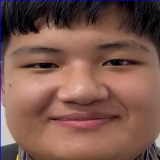

In [ ]:
my_face

# Automate the preprocessing

In [ ]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Fixed typo: cvtColoer → cvtColor
        try:
            faces = self.detector.detect_faces(img)
            if len(faces) == 0:
                return None
            x, y, w, h = faces[0]['box']
            x, y = abs(x), abs(y)
            face = img[y:y+h, x:x+w]
            face_arr = cv.resize(face, self.target_size)
            return face_arr
        except Exception as e:
            print(f"Error extracting face from {filename}: {str(e)}")
            return None

    def load_faces(self, dir, batch_size=100):
        FACES = []
        labels = []

        # Get all image files
        image_files = [f for f in os.listdir(dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_name = os.path.basename(os.path.normpath(dir))

        # Process in batches
        total_batches = (len(image_files) + batch_size - 1) // batch_size  # Ceiling division

        for batch_idx in range(total_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(image_files))
            batch_files = image_files[start_idx:end_idx]

            batch_faces = []
            for im_name in batch_files:
                try:
                    path = os.path.join(dir, im_name)
                    single_face = self.extract_face(path)
                    if single_face is not None:
                        batch_faces.append(single_face)
                except Exception as e:
                    print(f"Error processing {im_name}: {str(e)}")

            FACES.extend(batch_faces)
            batch_labels = [class_name for _ in range(len(batch_faces))]
            labels.extend(batch_labels)

            print(f"Batch {batch_idx+1}/{total_batches} for class {class_name}: Loaded {len(batch_faces)} faces")

        print(f"Total loaded for class {class_name}: {len(FACES)} faces")
        return FACES, labels

    def load_classes(self, batch_size=100):
        self.X = []
        self.Y = []

        # Get all subdirectories (classes)
        subdirs = [d for d in os.listdir(self.directory) if os.path.isdir(os.path.join(self.directory, d))]

        for sub_dir in subdirs:
            path = os.path.join(self.directory, sub_dir)
            faces, labels = self.load_faces(path, batch_size)

            if faces:
                self.X.extend(faces)
                self.Y.extend(labels)

        print(f"Total dataset loaded: {len(self.X)} images across {len(subdirs)} classes")
        return np.asarray(self.X), np.asarray(self.Y)

    def plot_images(self, max_images=9):
        """Plot a sample of the loaded images"""
        num_images = min(max_images, len(self.X))
        if num_images == 0:
            print("No images to display")
            return

        ncols = 3
        nrows = (num_images + ncols - 1) // ncols + 1 # Ceiling division

        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            plt.subplot(nrows, ncols, i+1)
            plt.imshow(self.X[i])
            plt.title(self.Y[i], fontsize=8)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
faceloading = FACELOADING('/content/unzipped_files/Images')
X,Y = faceloading.load_classes()

Batch 1/1 for class Jimpa: Loaded 10 faces
Total loaded for class Jimpa: 10 faces
Batch 1/1 for class Suzal: Loaded 10 faces
Total loaded for class Suzal: 10 faces
Batch 1/1 for class Nima: Loaded 10 faces
Total loaded for class Nima: 10 faces
Batch 1/1 for class Norphel: Loaded 10 faces
Total loaded for class Norphel: 10 faces
Batch 1/1 for class Jigme: Loaded 10 faces
Total loaded for class Jigme: 10 faces
Batch 1/1 for class Dechen: Loaded 10 faces
Total loaded for class Dechen: 10 faces
Batch 1/1 for class unknown: Loaded 11 faces
Total loaded for class unknown: 11 faces
Batch 1/1 for class ST: Loaded 10 faces
Total loaded for class ST: 10 faces
Batch 1/1 for class penjor: Loaded 10 faces
Total loaded for class penjor: 10 faces
Batch 1/1 for class TKP: Loaded 10 faces
Total loaded for class TKP: 10 faces
Batch 1/1 for class PemaLhamo: Loaded 11 faces
Total loaded for class PemaLhamo: 11 faces
Total dataset loaded: 112 images across 11 classes


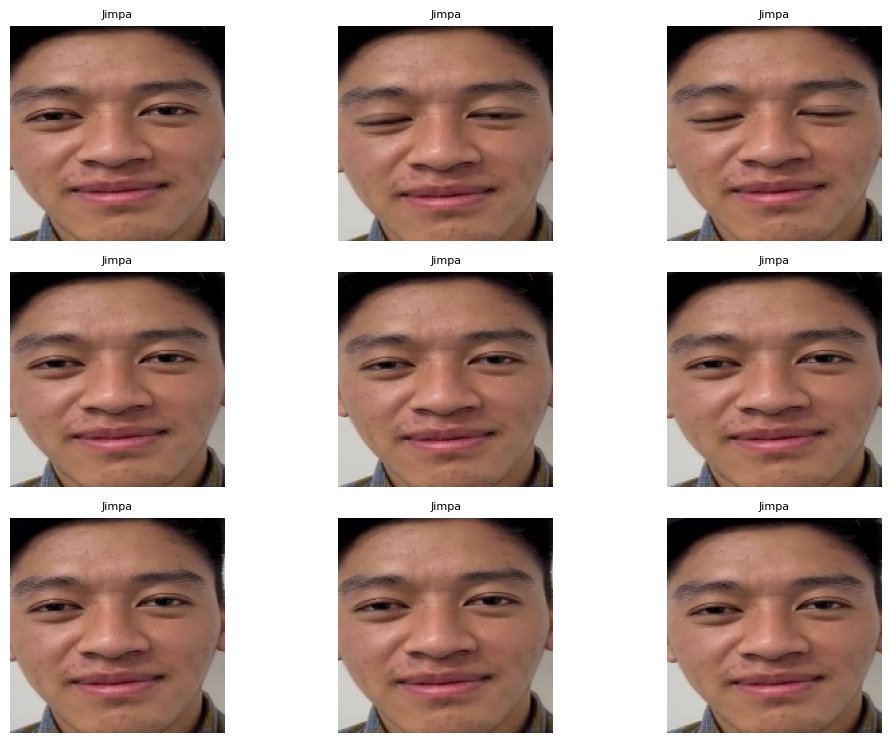

In [ ]:
faceloading.plot_images()

# FaceNet Part

In [ ]:
!pip install keras-facenet

In [ ]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D (160x160x3)
    face_img = np.expand_dims(face_img,axis=0)

    # 4D (Nonex160x160x3)
    yhat = embedder.embeddings(face_img)
    return yhat[0]


In [ ]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
np.savez_compressed('faces_embeddings.npz',EMBEDDED_X, Y)

# SVM Model

In [ ]:
Y

array(['Jimpa', 'Jimpa', 'Jimpa', 'Jimpa', 'Jimpa', 'Jimpa', 'Jimpa',
       'Jimpa', 'Jimpa', 'Jimpa', 'Suzal', 'Suzal', 'Suzal', 'Suzal',
       'Suzal', 'Suzal', 'Suzal', 'Suzal', 'Suzal', 'Suzal', 'Nima',
       'Nima', 'Nima', 'Nima', 'Nima', 'Nima', 'Nima', 'Nima', 'Nima',
       'Nima', 'Norphel', 'Norphel', 'Norphel', 'Norphel', 'Norphel',
       'Norphel', 'Norphel', 'Norphel', 'Norphel', 'Norphel', 'Jigme',
       'Jigme', 'Jigme', 'Jigme', 'Jigme', 'Jigme', 'Jigme', 'Jigme',
       'Jigme', 'Jigme', 'Dechen', 'Dechen', 'Dechen', 'Dechen', 'Dechen',
       'Dechen', 'Dechen', 'Dechen', 'Dechen', 'Dechen', 'unknown',
       'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
       'unknown', 'unknown', 'unknown', 'unknown', 'ST', 'ST', 'ST', 'ST',
       'ST', 'ST', 'ST', 'ST', 'ST', 'ST', 'penjor', 'penjor', 'penjor',
       'penjor', 'penjor', 'penjor', 'penjor', 'penjor', 'penjor',
       'penjor', 'TKP', 'TKP', 'TKP', 'TKP', 'TKP', 'TKP', 'TKP', 'TKP',
     

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y= encoder.transform(Y)

In [ ]:
Y

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True,random_state=17)

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [ ]:
ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)

# Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypred_train)
accuracy_score(Y_test, ypred_test)

0.9285714285714286

# Testing the pretrained model

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Face.jpg to Face.jpg


In [ ]:

t_im = cv.imread("/content/Face.jpg")


if t_im is None:
    print("Error: Image not found or path is incorrect.")
else:
    t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)

    x, y, w, h = detector.detect_faces(t_im)[0]['box']

    print(f"Face detected at: x={x}, y={y}, width={w}, height={h}")


Face detected at: x=263, y=227, width=218, height=287


In [ ]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im,(160,160))
test_im = get_embedding(t_im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


In [ ]:
test_im = [test_im]
ypreds= model.predict(test_im)

In [ ]:
ypreds

array([8])

In [ ]:
print(f"This person is: {encoder.inverse_transform(ypreds)[0]}")


This person is: TKP


# Saving the Pre-trained model

In [ ]:
# Saving the pretrained model
from keras_facenet import FaceNet

# Load the pretrained model
facenet_model = FaceNet()
model = facenet_model.model  # This is the Keras model object

# Save the model to .h5 format
model.save("facenet_pretrained.h5")
print("✅ Model saved as 'facenet_pretrained.h5'")

✅ Model saved as 'facenet_pretrained.h5'


In [ ]:
# Save the model to the new .keras format
model.save("facenet_pretrained.keras")
print("✅ Model saved as 'facenet_pretrained.keras'")


✅ Model saved as 'facenet_pretrained.keras'


# Loading the model for fine-tuning

In [ ]:
from keras.saving import register_keras_serializable
import tensorflow as tf

@register_keras_serializable()
def l2_normalize(x, axis=1):
    return tf.nn.l2_normalize(x, axis)


In [ ]:
from keras.models import load_model
from keras.saving import register_keras_serializable
import tensorflow as tf

# Register the scaling function
@register_keras_serializable()
def scaling(x, scale=0.17):
    return x * scale

# Register the l2_normalize function
@register_keras_serializable()
def l2_normalize(x, axis=1):
    return tf.nn.l2_normalize(x, axis)

# Load the model with custom objects
model = load_model('facenet_pretrained.keras', custom_objects={'scaling': scaling, 'l2_normalize': l2_normalize})

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


# Fine tuning the model

In [ ]:
from tensorflow.keras.optimizers import Adam

# 1. Unfreeze last N layers for gradual fine-tuning
for layer in model.layers[-3:]:  # Last 3 layers trainable
    layer.trainable = True

# 2. Freeze all other layers
for layer in model.layers[:-3]:
    layer.trainable = False

# 3. Use lower learning rate for stable fine-tuning
optimizer = Adam(learning_rate=1e-5)  # Small LR to avoid overwriting useful features

# 4. Recompile the model to apply changes
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Adjust loss if needed (e.g., sparse_categorical_crossentropy)
    metrics=['accuracy']
)

# 5. Verify trainable layers
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name} | Trainable: {layer.trainable}")

Layer 0: input_layer_1 | Trainable: False
Layer 1: Conv2d_1a_3x3 | Trainable: False
Layer 2: Conv2d_1a_3x3_BatchNorm | Trainable: False
Layer 3: Conv2d_1a_3x3_Activation | Trainable: False
Layer 4: Conv2d_2a_3x3 | Trainable: False
Layer 5: Conv2d_2a_3x3_BatchNorm | Trainable: False
Layer 6: Conv2d_2a_3x3_Activation | Trainable: False
Layer 7: Conv2d_2b_3x3 | Trainable: False
Layer 8: Conv2d_2b_3x3_BatchNorm | Trainable: False
Layer 9: Conv2d_2b_3x3_Activation | Trainable: False
Layer 10: MaxPool_3a_3x3 | Trainable: False
Layer 11: Conv2d_3b_1x1 | Trainable: False
Layer 12: Conv2d_3b_1x1_BatchNorm | Trainable: False
Layer 13: Conv2d_3b_1x1_Activation | Trainable: False
Layer 14: Conv2d_4a_3x3 | Trainable: False
Layer 15: Conv2d_4a_3x3_BatchNorm | Trainable: False
Layer 16: Conv2d_4a_3x3_Activation | Trainable: False
Layer 17: Conv2d_4b_3x3 | Trainable: False
Layer 18: Conv2d_4b_3x3_BatchNorm | Trainable: False
Layer 19: Conv2d_4b_3x3_Activation | Trainable: False
Layer 20: Block35_1_Bra

# Collecting dataset for analysis

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Images (2).zip to Images (2) (1).zip


In [ ]:
import zipfile

# Path to the uploaded ZIP file
zip_path = list(uploaded.keys())[0]  # Get the name of the uploaded file

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('unzipped_file')  # Extract to a folder named 'unzipped_files'

print("Files unzipped successfully!")

Files unzipped successfully!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have your images stored in folders for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Specify the directory paths for your training and validation datasets
train_directory = '/content/unzipped_file/Images/Train'
val_directory = '/content/unzipped_file/Images/Val'

# Prepare the data generators
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),  # Resize images to the required size for FaceNet
    batch_size=32,
    class_mode='categorical')  # For multi-class classification

val_generator = val_datagen.flow_from_directory(
    val_directory,
    target_size=(224, 224),  # Resize images to the required size for FaceNet
    batch_size=32,
    class_mode='categorical')  # For multi-class classification


Found 88 images belonging to 8 classes.
Found 16 images belonging to 8 classes.


# Compiling the model

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Get the original model (without the last classification layer)
x = model.output

# Add a fully connected layer for classification
x = Dense(8, activation='softmax')(x)  # 8 classes, softmax activation

# Create the final model
new_model = Model(inputs=model.input, outputs=x)

# Compile the new model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Training my dataset on fine tuned model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Training configuration
history = new_model.fit(
    train_generator,
    epochs=20,
    batch_size=4,
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.4596 - loss: 1.9231 - val_accuracy: 1.0000 - val_loss: 1.6684
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.9826 - loss: 1.4006 - val_accuracy: 1.0000 - val_loss: 1.4155
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 1.0000 - loss: 1.1595 - val_accuracy: 1.0000 - val_loss: 1.2761
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 1.0000 - loss: 1.0517 - val_accuracy: 1.0000 - val_loss: 1.1911
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 1.0000 - loss: 0.9825 - val_accuracy: 1.0000 - val_loss: 1.1305
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 1.0000 - loss: 0.9222 - val_accuracy: 1.0000 - val_loss: 1.0809
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 1.0000 - loss: 0.8854 - val_accuracy: 1.0000 - val_loss: 1.0367
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 1.0000 - loss: 0.8460 - val_accuracy: 1.0000 - val_loss: 0.9951
Epoch 9/

# Compare Training vs. Validation metrics

In [ ]:
print(f"Training Accuracy: {history.history['accuracy'][-1]:.2f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.2f}")

Training Accuracy: 1.00
Validation Accuracy: 1.00


# Saving the fine-tuned model

In [ ]:
from keras.models import save_model
from keras.saving import register_keras_serializable
import tensorflow as tf

# Define and register custom functions (same as your loading code)
@register_keras_serializable()
def scaling(x, scale=0.17):
    return x * scale

@register_keras_serializable()
def l2_normalize(x, axis=1):
    return tf.nn.l2_normalize(x, axis)

# Save the fine-tuned model with custom objects
save_model(
    new_model,  # Your fine-tuned model
    'fine_tuned_model.keras',  # Or .h5
    save_format='keras',  # Modern format (recommended)
    overwrite=True,
    include_optimizer=True  # Optional: Set to False for inference-only
)

print("✅ Model saved with custom functions!")

✅ Model saved with custom functions!


# Optimizing model for App

In [ ]:
# Initialize the converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Optional) Optimize for size/performance
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Quantization

# Convert to TFLite
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/fine_tuned_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ TFLite conversion successful!")

Saved artifact at '/tmp/tmp0_sq5x11'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 512), dtype=tf.float32, name=None)
Captures:
  132269378935632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269378941968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269378944080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269378944656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269378943888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269377176976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269377176592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269378943312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269377177744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269377176784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269377

# Downloading models

In [13]:
# import shutil

# # Path to the directory you want to delete
# directory_path = '/content/FaceNet-Model'

# # Delete the directory and its contents
# shutil.rmtree(directory_path)


In [ ]:
from google.colab import files
files.download('/content/facenet_pretrained.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('/content/fine_tuned_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('/content/fine_tuned_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>